# Import Required Libraries

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Load Clean Subset of PaySim Data

In [2]:
df = pd.read_csv('../data/processed/paysim_subset.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
1,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
2,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
3,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
4,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0


# Build the Directed Graph

In [3]:
G = nx.DiGraph()

# Add edges: from -> to with attributes
for idx, row in df.iterrows():
    G.add_edge(
        row['nameOrig'], 
        row['nameDest'], 
        amount=row['amount'], 
        isFraud=row['isFraud']
    )

# Basic Network Stats

In [4]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 9982
Number of edges: 5000


# Centrality Analysis
### Identify influential accounts based on how connected or central they are.

Top nodes by degree centrality: [('C1938475526', 0.00020038072337441137), ('C550754064', 0.00020038072337441137), ('C1027773814', 0.00020038072337441137), ('C1975918135', 0.00020038072337441137), ('C541258645', 0.00020038072337441137)]


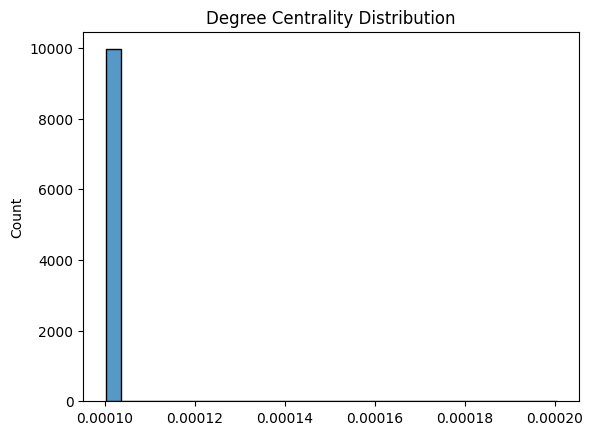

In [5]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Top 5 central nodes by degree
sorted_dc = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top nodes by degree centrality:", sorted_dc)

# Optionally visualize distribution
sns.histplot(list(degree_centrality.values()), bins=30)
plt.title("Degree Centrality Distribution")
plt.show()

# Community Detection (Weakly Connected Components)
### This can give an early sense of isolated fraud rings.

In [6]:
components = list(nx.weakly_connected_components(G))
print(f"Number of weakly connected components: {len(components)}")

# Print size of top 5 components
component_sizes = sorted([len(c) for c in components], reverse=True)[:5]
print("Top 5 community sizes:", component_sizes)

Number of weakly connected components: 4982
Top 5 community sizes: [3, 3, 3, 3, 3]


# Spotting Potential Anomalies
### Accounts with many transactions, or only inflow/outflow, might be suspicious.

In [7]:
suspicious = []
for node in G.nodes():
    in_deg = G.in_degree(node)
    out_deg = G.out_degree(node)
    
    if in_deg == 0 or out_deg == 0:
        suspicious.append(node)

print(f"Accounts with only one-sided flow: {len(suspicious)}")

Accounts with only one-sided flow: 9982


# Save Useful Data for Future Steps

In [9]:
import pickle

with open("../data/processed/transaction_graph.gpickle", "wb") as f:
    pickle.dump(G, f)

with open("../data/processed/transaction_graph.gpickle", "rb") as f:
    G = pickle.load(f)